In [1]:
!pip install pyro-ppl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install scikit-learn==0.22.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import torch
from torch import nn
import torch.distributions as dist
import matplotlib.pyplot as plt
import scipy.stats as st
import pandas as pd
import math
import os
import arviz as az
import random
%matplotlib inline

import seaborn as sns
sns.set_style("white")
plt.rcParams.update({'font.size': 9})

import warnings
warnings.filterwarnings("ignore")

np.random.seed(37)
torch.manual_seed(37)
random.seed(37)

## Inverse problem
$$\textbf{y} = \text{observed variable}$$ 
$$\boldsymbol{\xi} = \text{latent variable} = \text{center of the defect}$$
$$\boldsymbol{\xi} \in 	\mathbb{R}^2$$
$$p(\boldsymbol{\xi}|\textbf{y}) \propto p(\textbf{y}|\boldsymbol{\xi}) p(\boldsymbol{\xi})$$
$$\text{Prior: } p(\boldsymbol{\xi})$$
$$\text{Likelihood: } p(\textbf{y}|\boldsymbol{\xi})$$

In [4]:
from utilities3 import *
from networks import *

class EIT_fipy():
    """
    Class that solves forward electrostatic EIT BVP for different boundary conditions using fipy package for a circular damage.
    x_centers:  Location of the damage centers.
    """
    def __init__(self, x_centers):
        
        # defects with radius r=0.1 at x_centers
        self.x_centers = x_centers # (N x 2)

        self.Expts_description = {
                                'Expt-1': 'Unit current applied on all the sides',
                                'Expt-2': 'Unit current on left and right, no current on the other sides',
                                'Expt-3': 'Unit current on top and bottom, no current on the other sides'
                                }
        
            
    def forward_process_preds(self):
        
        u_preds_dict = {}
        
        for expt in self.Expts_description.keys():
        
            xc_normalizer = load_object('x_normalizer_'+expt+'.pkl')
            u_normalizer = load_object('y_normalizer_'+expt+'.pkl')

            x_centers_ = xc_normalizer.encode(self.x_centers)

            model_surrogate_state_dict = torch.load('model_state_dict_'+expt+'.pt')
            model_surrogate = DenseResNet(dim_in=x_centers_.shape[1], dim_out=200, num_resnet_blocks=5, 
                     num_layers_per_block=3, num_neurons=60, activation=nn.SiLU())
            model_surrogate.load_state_dict(model_surrogate_state_dict)

            u_preds_dict[expt] = u_normalizer.decode(model_surrogate(x_centers_))
        
        u_preds = torch.hstack((u_preds_dict['Expt-1'], u_preds_dict['Expt-2'], u_preds_dict['Expt-3']))
        return u_preds

In [5]:
import torch
a, b = torch.tensor(0.2, requires_grad=True), torch.tensor(0.8, requires_grad=True)
        
def outer(x1_center, x2_center):
    if((x1_center<a) and (a<x2_center<b)):
        x1_center = x1_center - x1_center + a
        x2_center = x2_center
    elif((x1_center>b) and (a<x2_center<b)):
        x1_center = x1_center - x1_center + b
        x2_center = x2_center
    elif((a<x1_center<b) and (x2_center>b)):
        x1_center = x1_center
        x2_center = x2_center - x2_center + b
    elif((a<x1_center<b) and (x2_center<a)):
        x1_center = x1_center
        x2_center =  x2_center - x2_center + a
    elif((x1_center<a) and (x2_center<a)):
        x1_center, x2_center = x1_center - x1_center + a, x2_center - x2_center + a
    elif((x1_center<a) and (x2_center>b)):
        x1_center, x2_center = x1_center - x1_center + a, x2_center - x2_center + b
    elif((x1_center>b) and (x2_center>b)):
        x1_center, x2_center = x1_center - x1_center + b, x2_center - x2_center + b
    else: #((x1_center>b) and (x2_center<a))
        x1_center, x2_center = x1_center - x1_center + b, x2_center - x2_center + a
    return x1_center, x2_center

def closest_point(x1_center, x2_center):
    if((a<=x1_center<=b) and (a<=x2_center<=b)):
        x1_center = x1_center
        x2_center = x2_center
    else:
        x1_center, x2_center = outer(x1_center, x2_center)
    return x1_center, x2_center

In [6]:
def forward_process(xi): # N x 2 
    xi = xi.reshape(-1,2)
    
    # As forward electrostatic EIT BVP is well defined for x_center in range [0.2, 0.8]^2, we wrap it around a 
    # function that maps anything outside [0.2, 0.8]^2 to the closest point in [0.2, 0.8]^2.
    x_centers = torch.zeros_like(xi)
    for i in range(xi.shape[0]):
        x1_center, x2_center = closest_point(xi[i,0], xi[i,1])
        x_center = torch.hstack((x1_center, x2_center))
        x_centers[i] = x_center
    
    outputs = EIT_fipy(x_centers).forward_process_preds()

    return outputs

In [7]:
class ResNet(torch.nn.Module):
    """
    Implements the residual network
    """
    def __init__(self, module):
        super().__init__()
        self.module = module

    def forward(self, inputs):
        return self.module(inputs) + inputs

In [8]:
def unpack_cholesky(L_diag, L_offdiag, xi_dim):
    """
    Constructs cholesky L matrix from diagonal and offdiagonal elements.
    """
    chol_diag = torch.diag(L_diag)
    
    chol_offdiag = torch.zeros((xi_dim, xi_dim))
    tril_indices = torch.tril_indices(row=xi_dim, col=xi_dim, offset=-1)
    chol_offdiag[tril_indices[0], tril_indices[1]] = L_offdiag

    q_L = chol_diag + chol_offdiag # here q_L is L matrix
    return q_L 

In [9]:
class Amortized_VI(nn.Module):
    """
    Class that performs Amortized Variational inference.
    xi_dim: Number of dimensions in the variables to infer.
    y_dim: Number of measurement observations.
    prior_xi_dist: prior distribution defined using torch.distributions.
    f: function defining the forward process.
    noise_scale: Standard deviation of likelihood or the measurement process.
    """
    def __init__(self, xi_dim=2, y_dim=600, prior_xi_dist=None, f=forward_process, noise_scale = 0.005):
        super().__init__()
        
        self.xi_dim = xi_dim
        self.y_dim = y_dim
        self.prior_xi_dist = prior_xi_dist
        self.f = f
        self.noise_scale = noise_scale
        
        self.mu = nn.Sequential(
            nn.Linear(self.y_dim, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, self.xi_dim))
        
        self.L_diag = nn.Sequential(
            nn.Linear(self.y_dim, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, self.xi_dim),
            nn.Softplus()
        )
        
        self.L_offdiag = nn.Sequential(
            nn.Linear(self.y_dim, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, int(self.xi_dim*(self.xi_dim+1)/2)-self.xi_dim)
        )
        
    def observed_data(self, n=30):
        xi_data = dist.Uniform(low=torch.tensor([0.2, 0.2]), high=torch.tensor([0.8, 0.8])).sample([n]) 
        y_data = self.f(xi_data) + self.noise_scale * torch.randn(*self.f(xi_data).shape)
        return xi_data, y_data
    
    def forward(self, num_particles=2):
        _, y = self.observed_data(n=32)
        
        q_mu = self.mu(y)
        q_L_diag = self.L_diag(y)
        q_L_offdiag = self.L_offdiag(y) #or 0.01*self.L_offdiag(y)

        #print(q_mu, q_L_diag, q_L_offdiag)
        
        loss = 0
        for j in range(y.shape[0]):
            
            ##### elbo for one data point 
            q_Lj = unpack_cholesky(q_L_diag[j,:], q_L_offdiag[j,:], self.xi_dim) # q_Lj is L matrix    
            
            xi_samples = torch.zeros(num_particles, self.xi_dim)
            for k in range(num_particles):
                zs = torch.randn_like(q_mu[j,:])
                xi_samples[k] = q_mu[j,:] + torch.matmul(q_Lj, zs)# reparametrization

            datafit = 0.
            for i in range(num_particles):
                log_prior = self.prior_xi_dist.log_prob(xi_samples[i]).sum()
                log_likelihood = dist.Normal(loc=self.f(xi_samples[i])[0], scale=self.noise_scale).log_prob(y[j,:]).sum()
                log_joint = log_prior + log_likelihood
                # print(log_prior, log_likelihood)
                datafit += log_joint
            datafit = datafit/num_particles

            entropy = dist.MultivariateNormal(loc=q_mu[j,:], scale_tril=q_Lj).entropy()
            # print(entropy)
            elbo = datafit + entropy
            #####
            loss += elbo
        
        return loss/y.shape[0]

step 0: loss = -2139, learning rate = 0.01000
step 500: loss = -2310, learning rate = 0.01000
step 1000: loss = -2319, learning rate = 0.01000
step 1500: loss = -2317, learning rate = 0.01000
step 2000: loss = -2324, learning rate = 0.01000
step 2500: loss = -2316, learning rate = 0.01000
step 3000: loss = -2325, learning rate = 0.01000
step 3500: loss = -2321, learning rate = 0.01000
step 4000: loss = -2321, learning rate = 0.00100
step 4500: loss = -2321, learning rate = 0.00100
step 5000: loss = -2319, learning rate = 0.00100
step 5500: loss = -2327, learning rate = 0.00100
step 6000: loss = -2324, learning rate = 0.00100
step 6500: loss = -2322, learning rate = 0.00100
step 7000: loss = -2320, learning rate = 0.00100
step 7500: loss = -2326, learning rate = 0.00100


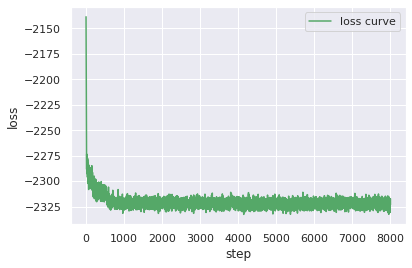

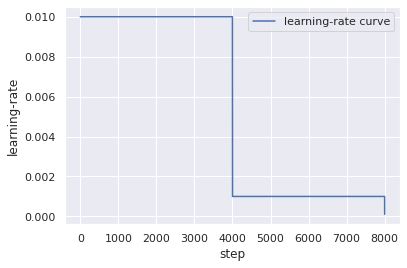

In [ ]:
xi_dim = 2
y_dim = 600
# Defining prior distribution
prior_xi_dist = dist.Normal(loc=0.5*torch.ones(xi_dim), scale=0.1*torch.ones(xi_dim))
noise_scale = 0.005
model = Amortized_VI(xi_dim=xi_dim, y_dim=y_dim, prior_xi_dist=prior_xi_dist, f=forward_process, noise_scale=noise_scale)

# Training
optim = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=4000, gamma=0.1)

n_steps = 8000

steps, losses, learning_rates = [], [], []
for step in range(n_steps):
    optim.zero_grad()
    loss = - model(num_particles=5)
    loss.backward()
    #torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
    optim.step()
    scheduler.step()
    
    steps.append(step)
    losses.append(loss.item())
    learning_rates.append(optim.state_dict()['param_groups'][0]['lr'])
    
    if step % 500 == 0: 
        print('step %s:' % step, 'loss = %.0f,' % loss, 
              'learning rate = %.5f' % optim.state_dict()['param_groups'][0]['lr']) 
        
plt.figure()
plt.plot(steps, losses, 'g', label = 'loss curve')
plt.xlabel('step')
plt.ylabel('loss')
plt.legend()

plt.figure()
plt.plot(steps, learning_rates, 'b', label = 'learning-rate curve')
plt.xlabel('step')
plt.ylabel('learning-rate')
plt.legend()

In [ ]:
save = True
if save==True:
    torch.save(model.state_dict(), 'model_state_dict_AVI.pt')

In [10]:
xi_dim = 2
y_dim = 600
# Defining prior distribution
prior_xi_dist = dist.Normal(loc=0.5*torch.ones(xi_dim), scale=0.1*torch.ones(xi_dim))
noise_scale = 0.005
model = Amortized_VI(xi_dim=xi_dim, y_dim=y_dim, prior_xi_dist=prior_xi_dist, f=forward_process, noise_scale=noise_scale)
model.load_state_dict(torch.load('model_state_dict_AVI.pt'))

<All keys matched successfully>

In [11]:
sns.set_style("white")
plt.rcParams.update({'font.size': 9})

def pair_plot(df, xi_data, j):
    fig, axes = plt.subplots(len(xi_data[0]), len(xi_data[0]), figsize = (6,4), sharex="col", tight_layout=True)

    COLUMNS = list(df.columns)
    COLUMNS.remove('Sample type')

    for i in range(len(COLUMNS)):
        for k in range(len(COLUMNS)):
            
            # If this is the lower-triangule, add a scatterlpot for each group.
            if i > k:
                a = sns.scatterplot(data=df, x=COLUMNS[k], y=COLUMNS[i], 
                                  hue="Sample type", ax=axes[i, k], s=10, legend=False)
                a.set(xlabel=None)
                a.set(ylabel=None)

            # If this is the main diagonal, add kde plot
            if i == k:
                b = sns.kdeplot(data=df, x=COLUMNS[k], hue="Sample type",  common_norm=False, ax=axes[i, k])
                axes[i, k].axvline(x=xi_data[0][k], color = 'black', ls ='--')
                b.set(xlabel=None)
                b.set(ylabel=None)

                if k == 0:
                    sns.move_legend(b, "center right", bbox_to_anchor=(3.4,0), title=None,frameon=True,)
                    #sns.move_legend(b, "lower center", bbox_to_anchor=(2.5, 1), ncol=3, title=None,frameon=True,)
                else:
                    axes[i, k].legend([],[], frameon=False)

            # If on the upper triangle
            if i < k:
                axes[i, k].remove()
                      
    for i in range(len(COLUMNS)):
        k=0
        axes[i, k].set_ylabel(COLUMNS[i])
      
    for k in range(len(COLUMNS)):
        i=len(COLUMNS)-1
        axes[i, k].set_xlabel(COLUMNS[k])
    
    #plt.subplots_adjust(wspace=0.25, hspace=0.4)

    if save==True:
        plt.savefig(results_dir +str(j)+'_pairplot'+'.pdf', dpi=300, bbox_inches='tight')
    # See the chart now
    plt.show()
    plt.close()

0
Groundtruth:
 xi_data=[[0.21589163 0.6217499 ]]
Estimated mean:
[0.26489905 0.61097157]
Estimated covariance matrix:
[[ 0.00073307 -0.0001549 ]
 [-0.0001549   0.00071182]]


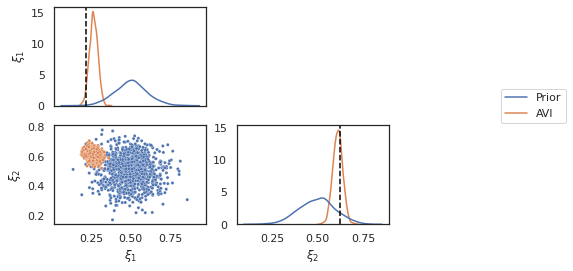

------------------------------------------------------------------------------------------
1
Groundtruth:
 xi_data=[[0.24978735 0.59957427]]
Estimated mean:
[0.25750008 0.6229067 ]
Estimated covariance matrix:
[[ 0.00074741 -0.00015641]
 [-0.00015641  0.00072388]]


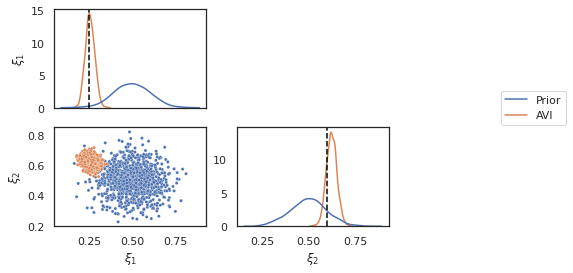

------------------------------------------------------------------------------------------
2
Groundtruth:
 xi_data=[[0.45537442 0.43965527]]
Estimated mean:
[0.48693916 0.46562642]
Estimated covariance matrix:
[[ 0.00067443 -0.00014858]
 [-0.00014858  0.00066243]]


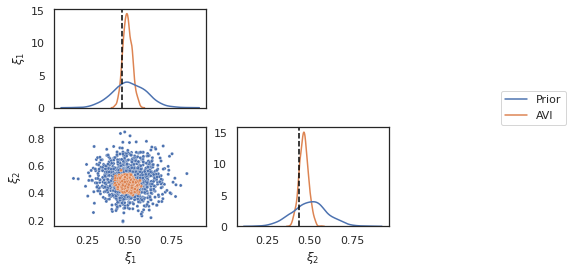

------------------------------------------------------------------------------------------


In [12]:
save = False

n_samples = 1000 # number of posterior samples

for j in range(3):

    print(j)
    
    xi_data, y_data = model.observed_data(n=1)
    print('Groundtruth:\n xi_data='+str(xi_data.data.numpy()))
    #print('Groundtruth:\n y_data='+str(y_data.data.numpy()))

    mean = (model.mu(y_data))[0, :]
    L_diag = model.L_diag(y_data)
    L_offdiag = model.L_offdiag(y_data) #or 0.01*self.L_offdiag(y)
    L = unpack_cholesky(L_diag[0,:], L_offdiag[0,:], model.xi_dim) # L matrix

    print('Estimated mean:\n'+str(mean.data.numpy()))
    print('Estimated covariance matrix:\n'+str(torch.matmul(L,L.T).data.numpy()))
    
    xi_samples_AVI = torch.zeros(n_samples,model.xi_dim)
    for k in range(n_samples):
        zs = torch.randn_like(mean)
        xi_samples_AVI[k] = mean + torch.matmul(L, zs)
    # print(xi_samples_AVI.shape)

    ######
    Prior_data = prior_xi_dist.sample([n_samples]).T.data.numpy()
    Prior_dict = dict() 
    for i in range(Prior_data.shape[0]):
        Prior_dict[r'$\xi_{%.0f}$' % (i+1)] = Prior_data[i] 

    AVI_data = xi_samples_AVI.T.data.numpy()
    AVI_dict = dict() 
    for i in range(AVI_data.shape[0]):
        AVI_dict[r'$\xi_{%.0f}$' % (i+1)] = AVI_data[i]   

    df_Prior = pd.DataFrame(Prior_dict)
    df_AVI = pd.DataFrame(AVI_dict)
    df_Prior['Sample type'] = 'Prior'
    df_AVI['Sample type'] = 'AVI'

    df = pd.concat([df_Prior, df_AVI])
    df.reset_index(drop=True, inplace=True)
    pair_plot(df, xi_data, j)
    ######
    print('-'*90)

In [13]:
#list(model.named_parameters())

### Comparison of AVI vs MCMC:

In [14]:
import pyro
import pyro.distributions as dist_pyro
from pyro.infer import MCMC, HMC, NUTS

np.random.seed(37)
torch.manual_seed(37)
pyro.set_rng_seed(37)

In [15]:
save=True

results_dir = os.path.join(os.getcwd(), 'results/')
if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

In [16]:
xi_data_, y_data_ = model.observed_data(n=15)
print(xi_data_.shape, y_data_.shape)
print('Groundtruth:\n xi_data='+str(xi_data_.data.numpy()))
# print('Groundtruth:\n y_data='+str(y_data_.data.numpy()))

torch.save(xi_data_, results_dir +'xi_data.pt')
torch.save(y_data_, results_dir +'y_data.pt')

torch.Size([15, 2]) torch.Size([15, 600])
Groundtruth:
 xi_data=[[0.6746786  0.58512044]
 [0.6854794  0.2995451 ]
 [0.4133166  0.57135355]
 [0.7790535  0.3656599 ]
 [0.6449338  0.6162515 ]
 [0.29680938 0.28191528]
 [0.48800886 0.7476441 ]
 [0.70507777 0.33047032]
 [0.31198615 0.20161355]
 [0.7260165  0.37759316]
 [0.7595842  0.7343173 ]
 [0.56873137 0.2515977 ]
 [0.5198869  0.41162002]
 [0.5882784  0.41206422]
 [0.5894227  0.492338  ]]


0
Groundtruth:
 xi_data=[[0.6746786  0.58512044]]
0_AVI
Estimated mean:
[0.64195436 0.585765  ]
Estimated covariance matrix:
[[ 0.00065624 -0.00014656]
 [-0.00014656  0.00064697]]
torch.Size([1000, 2])
------------------------------------------------------------------------------------------
0_MCMC


Sample: 100%|██████████| 3300/3300 [06:30,  8.46it/s, step size=9.43e-01, acc. prob=0.915]


torch.Size([1000, 2])

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  input[0]      0.64      0.03      0.64      0.59      0.68   2765.46      1.00
  input[1]      0.59      0.03      0.59      0.54      0.63   1418.88      1.00

Number of divergences: 0
None
------------------------------------------------------------------------------------------


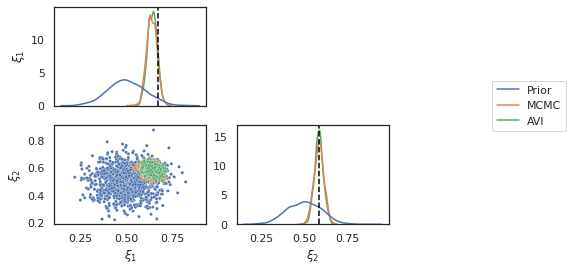

******************************************************************************************
1
Groundtruth:
 xi_data=[[0.6854794 0.2995451]]
1_AVI
Estimated mean:
[0.6417926  0.32007527]
Estimated covariance matrix:
[[ 0.00062523 -0.00014305]
 [-0.00014305  0.0006206 ]]
torch.Size([1000, 2])
------------------------------------------------------------------------------------------
1_MCMC


Sample: 100%|██████████| 3300/3300 [06:20,  8.68it/s, step size=8.13e-01, acc. prob=0.924]


torch.Size([1000, 2])

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  input[0]      0.66      0.03      0.66      0.62      0.70   1827.83      1.00
  input[1]      0.32      0.02      0.32      0.27      0.36   2345.19      1.00

Number of divergences: 0
None
------------------------------------------------------------------------------------------


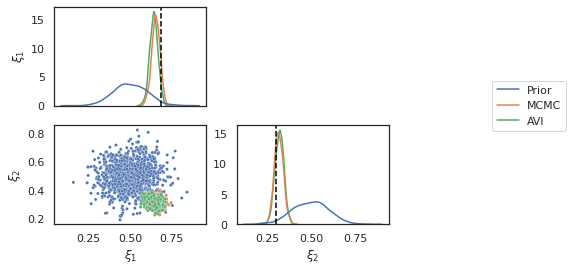

******************************************************************************************
2
Groundtruth:
 xi_data=[[0.4133166  0.57135355]]
2_AVI
Estimated mean:
[0.4540926  0.53413534]
Estimated covariance matrix:
[[ 0.00069397 -0.00015071]
 [-0.00015071  0.00067896]]
torch.Size([1000, 2])
------------------------------------------------------------------------------------------
2_MCMC


Sample: 100%|██████████| 3300/3300 [06:41,  8.22it/s, step size=6.65e-01, acc. prob=0.938]


torch.Size([1000, 2])

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  input[0]      0.46      0.03      0.47      0.41      0.52   1786.41      1.00
  input[1]      0.52      0.03      0.52      0.47      0.58   1709.21      1.00

Number of divergences: 0
None
------------------------------------------------------------------------------------------


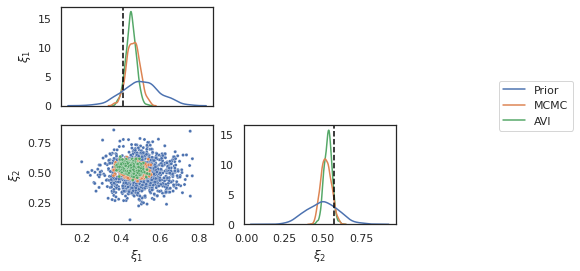

******************************************************************************************
3
Groundtruth:
 xi_data=[[0.7790535 0.3656599]]
3_AVI
Estimated mean:
[0.7323008  0.42063725]
Estimated covariance matrix:
[[ 0.00064907 -0.00014575]
 [-0.00014575  0.00064092]]
torch.Size([1000, 2])
------------------------------------------------------------------------------------------
3_MCMC


Sample: 100%|██████████| 3300/3300 [06:52,  7.99it/s, step size=6.06e-01, acc. prob=0.923]


torch.Size([1000, 2])

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  input[0]      0.75      0.02      0.75      0.71      0.78   1823.01      1.00
  input[1]      0.39      0.02      0.39      0.36      0.43   1316.24      1.00

Number of divergences: 0
None
------------------------------------------------------------------------------------------


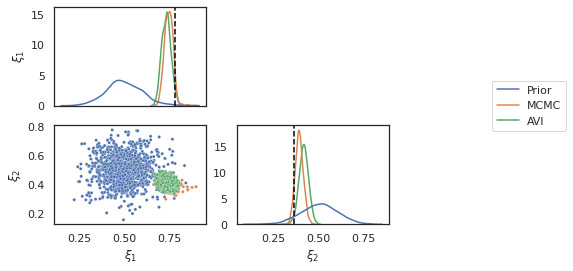

******************************************************************************************
4
Groundtruth:
 xi_data=[[0.6449338 0.6162515]]
4_AVI
Estimated mean:
[0.6352949 0.5968553]
Estimated covariance matrix:
[[ 0.00064847 -0.00014569]
 [-0.00014569  0.00064039]]
torch.Size([1000, 2])
------------------------------------------------------------------------------------------
4_MCMC


Sample: 100%|██████████| 3300/3300 [04:55, 11.17it/s, step size=9.41e-01, acc. prob=0.865]


torch.Size([1000, 2])

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  input[0]      0.65      0.03      0.65      0.61      0.70   2454.70      1.00
  input[1]      0.59      0.03      0.59      0.55      0.64   2567.50      1.00

Number of divergences: 0
None
------------------------------------------------------------------------------------------


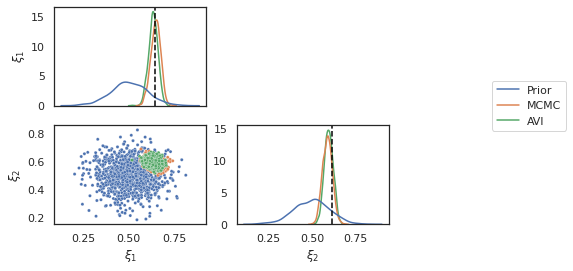

******************************************************************************************
5
Groundtruth:
 xi_data=[[0.29680938 0.28191528]]
5_AVI
Estimated mean:
[0.30706745 0.3172011 ]
Estimated covariance matrix:
[[ 0.00067259 -0.00014837]
 [-0.00014837  0.00066086]]
torch.Size([1000, 2])
------------------------------------------------------------------------------------------
5_MCMC


Sample: 100%|██████████| 3300/3300 [06:24,  8.59it/s, step size=8.61e-01, acc. prob=0.913]


torch.Size([1000, 2])

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  input[0]      0.29      0.03      0.29      0.25      0.34   2074.20      1.00
  input[1]      0.34      0.02      0.33      0.29      0.37   2046.17      1.00

Number of divergences: 0
None
------------------------------------------------------------------------------------------


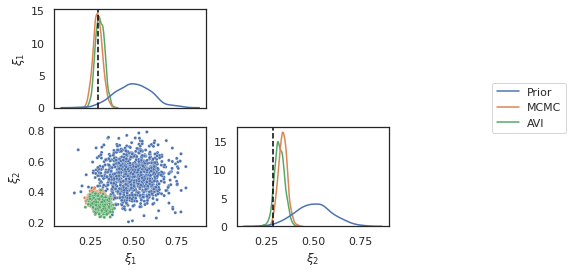

******************************************************************************************
6
Groundtruth:
 xi_data=[[0.48800886 0.7476441 ]]
6_AVI
Estimated mean:
[0.47210047 0.7933341 ]
Estimated covariance matrix:
[[ 0.00068958 -0.00015023]
 [-0.00015023  0.00067519]]
torch.Size([1000, 2])
------------------------------------------------------------------------------------------
6_MCMC


Sample: 100%|██████████| 3300/3300 [06:12,  8.85it/s, step size=8.70e-01, acc. prob=0.874]


torch.Size([1000, 2])

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  input[0]      0.50      0.02      0.50      0.46      0.54   1884.41      1.00
  input[1]      0.76      0.03      0.76      0.71      0.80   1843.55      1.00

Number of divergences: 0
None
------------------------------------------------------------------------------------------


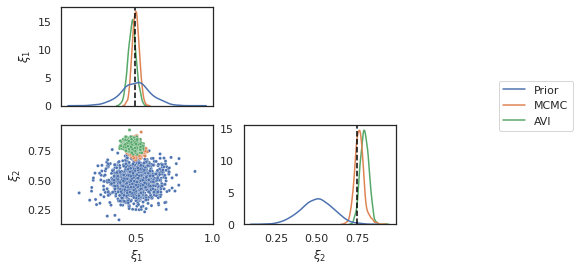

******************************************************************************************
7
Groundtruth:
 xi_data=[[0.70507777 0.33047032]]
7_AVI
Estimated mean:
[0.65574205 0.37388307]
Estimated covariance matrix:
[[ 0.00063695 -0.00014439]
 [-0.00014439  0.00063064]]
torch.Size([1000, 2])
------------------------------------------------------------------------------------------
7_MCMC


Sample: 100%|██████████| 3300/3300 [06:40,  8.24it/s, step size=7.31e-01, acc. prob=0.922]


torch.Size([1000, 2])

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  input[0]      0.66      0.03      0.66      0.61      0.70   1943.82      1.00
  input[1]      0.37      0.03      0.37      0.33      0.41   1805.17      1.00

Number of divergences: 0
None
------------------------------------------------------------------------------------------


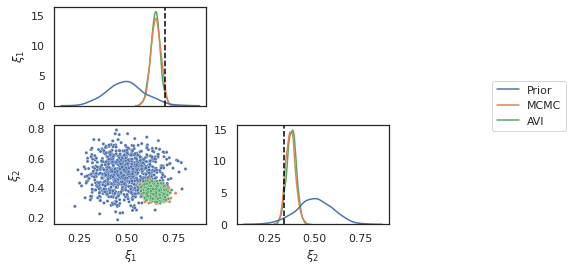

******************************************************************************************
8
Groundtruth:
 xi_data=[[0.31198615 0.20161355]]
8_AVI
Estimated mean:
[0.31511545 0.2047722 ]
Estimated covariance matrix:
[[ 0.00062832 -0.00014341]
 [-0.00014341  0.00062328]]
torch.Size([1000, 2])
------------------------------------------------------------------------------------------
8_MCMC


Sample: 100%|██████████| 3300/3300 [05:42,  9.63it/s, step size=8.26e-01, acc. prob=0.857]


torch.Size([1000, 2])

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  input[0]      0.31      0.02      0.31      0.28      0.34   2274.91      1.00
  input[1]      0.20      0.03      0.20      0.14      0.24   1245.77      1.00

Number of divergences: 0
None
------------------------------------------------------------------------------------------


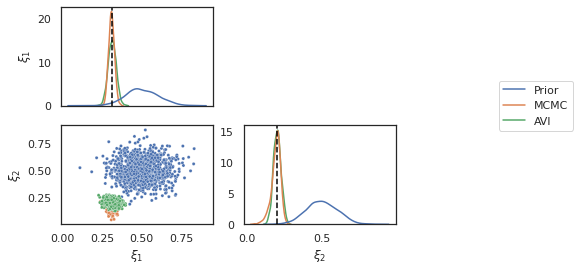

******************************************************************************************
9
Groundtruth:
 xi_data=[[0.7260165  0.37759316]]
9_AVI
Estimated mean:
[0.71941406 0.41814923]
Estimated covariance matrix:
[[ 0.00066087 -0.00014707]
 [-0.00014707  0.00065097]]
torch.Size([1000, 2])
------------------------------------------------------------------------------------------
9_MCMC


Sample: 100%|██████████| 3300/3300 [06:35,  8.34it/s, step size=8.83e-01, acc. prob=0.915]


torch.Size([1000, 2])

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  input[0]      0.70      0.02      0.70      0.67      0.75   1856.38      1.00
  input[1]      0.43      0.03      0.43      0.39      0.47   2957.87      1.00

Number of divergences: 0
None
------------------------------------------------------------------------------------------


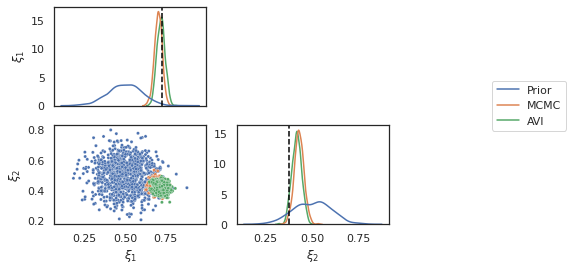

******************************************************************************************
10
Groundtruth:
 xi_data=[[0.7595842 0.7343173]]
10_AVI
Estimated mean:
[0.78518903 0.7691535 ]
Estimated covariance matrix:
[[ 0.00062806 -0.00014338]
 [-0.00014338  0.00062303]]
torch.Size([1000, 2])
------------------------------------------------------------------------------------------
10_MCMC


Sample: 100%|██████████| 3300/3300 [07:09,  7.69it/s, step size=6.71e-01, acc. prob=0.927]


torch.Size([1000, 2])

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  input[0]      0.75      0.02      0.75      0.72      0.79   1437.92      1.00
  input[1]      0.75      0.02      0.75      0.71      0.77   1305.10      1.00

Number of divergences: 0
None
------------------------------------------------------------------------------------------


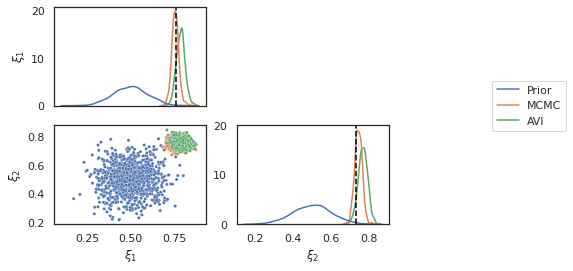

******************************************************************************************
11
Groundtruth:
 xi_data=[[0.56873137 0.2515977 ]]
11_AVI
Estimated mean:
[0.5630146  0.30357018]
Estimated covariance matrix:
[[ 0.00066854 -0.00014792]
 [-0.00014792  0.00065738]]
torch.Size([1000, 2])
------------------------------------------------------------------------------------------
11_MCMC


Sample: 100%|██████████| 3300/3300 [06:36,  8.33it/s, step size=8.10e-01, acc. prob=0.914]


torch.Size([1000, 2])

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  input[0]      0.58      0.03      0.58      0.54      0.62   2332.23      1.00
  input[1]      0.30      0.03      0.30      0.26      0.34   2202.52      1.00

Number of divergences: 0
None
------------------------------------------------------------------------------------------


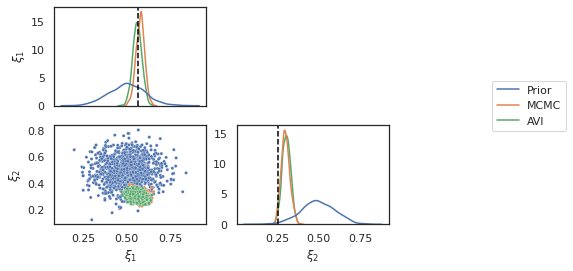

******************************************************************************************
12
Groundtruth:
 xi_data=[[0.5198869  0.41162002]]
12_AVI
Estimated mean:
[0.4805967  0.39680162]
Estimated covariance matrix:
[[ 0.00067178 -0.00014828]
 [-0.00014828  0.0006602 ]]
torch.Size([1000, 2])
------------------------------------------------------------------------------------------
12_MCMC


Sample: 100%|██████████| 3300/3300 [06:32,  8.41it/s, step size=8.12e-01, acc. prob=0.925]


torch.Size([1000, 2])

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  input[0]      0.48      0.03      0.48      0.43      0.53   1798.26      1.00
  input[1]      0.40      0.03      0.40      0.35      0.45   1840.87      1.00

Number of divergences: 0
None
------------------------------------------------------------------------------------------


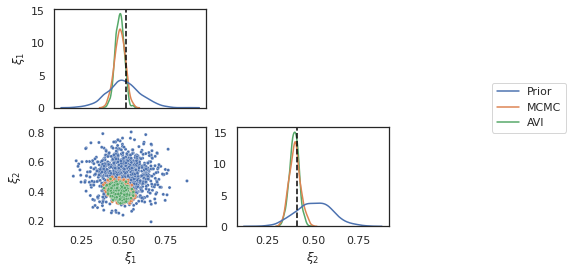

******************************************************************************************
13
Groundtruth:
 xi_data=[[0.5882784  0.41206422]]
13_AVI
Estimated mean:
[0.5552154 0.428107 ]
Estimated covariance matrix:
[[ 0.00065418 -0.00014633]
 [-0.00014633  0.00064523]]
torch.Size([1000, 2])
------------------------------------------------------------------------------------------
13_MCMC


Sample: 100%|██████████| 3300/3300 [06:42,  8.19it/s, step size=8.26e-01, acc. prob=0.924]


torch.Size([1000, 2])

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  input[0]      0.57      0.03      0.57      0.52      0.62   1527.65      1.00
  input[1]      0.43      0.03      0.43      0.39      0.48   2242.61      1.00

Number of divergences: 0
None
------------------------------------------------------------------------------------------


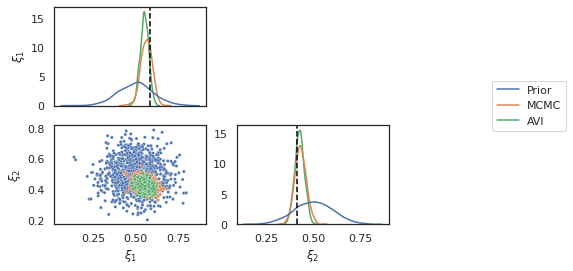

******************************************************************************************
14
Groundtruth:
 xi_data=[[0.5894227 0.492338 ]]
14_AVI
Estimated mean:
[0.5641085 0.4925148]
Estimated covariance matrix:
[[ 0.00067397 -0.00014852]
 [-0.00014852  0.00066206]]
torch.Size([1000, 2])
------------------------------------------------------------------------------------------
14_MCMC


Sample: 100%|██████████| 3300/3300 [06:33,  8.38it/s, step size=7.47e-01, acc. prob=0.919]


torch.Size([1000, 2])

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  input[0]      0.57      0.03      0.57      0.52      0.62   2575.88      1.00
  input[1]      0.49      0.03      0.49      0.43      0.54   1702.93      1.00

Number of divergences: 0
None
------------------------------------------------------------------------------------------


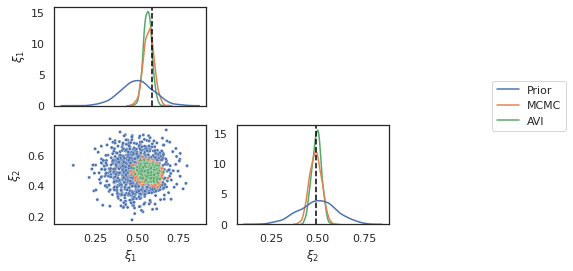

******************************************************************************************


In [17]:
n_samples = 1000 # number of posterior samples

for j in range(y_data_.shape[0]): 
    print(j)
    
    # Getting data
    xi_data, y_data = xi_data_[j].reshape(1,-1), y_data_[j].reshape(1,-1)
    print('Groundtruth:\n xi_data='+str(xi_data.data.numpy()))
    #print('Groundtruth:\n y_data='+str(y_data.data.numpy()))

    print(str(j)+'_AVI')
    # AVI_Full-rank-Gaussian
    mean = (model.mu(y_data))[0, :]
    L_diag = model.L_diag(y_data)
    L_offdiag = model.L_offdiag(y_data) #or 0.01*self.L_offdiag(y)
    L = unpack_cholesky(L_diag[0,:], L_offdiag[0,:], model.xi_dim) # L matrix

    print('Estimated mean:\n'+str(mean.data.numpy()))
    print('Estimated covariance matrix:\n'+str(torch.matmul(L,L.T).data.numpy()))

    xi_samples_AVI = torch.zeros(n_samples,model.xi_dim)
    for k in range(n_samples):
        zs = torch.randn_like(mean)
        xi_samples_AVI[k] = mean + torch.matmul(L, zs)
    print(xi_samples_AVI.shape)

    torch.save(xi_samples_AVI, results_dir +str(j)+'_AVI'+'_xi_samples.pt')
    print('-'*90)

    print(str(j)+'_MCMC')
    # MCMC
    def model_MCMC(data):
        xi = pyro.sample( "input", dist_pyro.Normal(loc=0.5*torch.ones(xi_dim), scale=0.1*torch.ones(xi_dim)) )
        pyro.sample("obs", dist_pyro.Normal(forward_process(xi).flatten(), scale=noise_scale), obs=data)

    hmc_kernel = HMC(model_MCMC, step_size=0.0855, num_steps=4)
    nuts_kernel= NUTS(model_MCMC, adapt_step_size=True)
    mcmc = MCMC(nuts_kernel, num_samples=int(n_samples*3), warmup_steps=300, num_chains=1)
    mcmc.run(y_data[0])
    
    thin = 3 #adjacent MCMC samples are correlated so computationally it can make sense to throw some samples out.
    xi_samples_MCMC = mcmc.get_samples()['input'][::thin,:]
    print(xi_samples_MCMC.shape)

    print(mcmc.summary())
    torch.save(xi_samples_MCMC, results_dir +str(j)+'_MCMC'+'_xi_samples.pt')
    print('-'*90)  

    ######
    Prior_data = prior_xi_dist.sample([n_samples]).T.data.numpy()
    Prior_dict = dict() 
    for i in range(Prior_data.shape[0]):
        Prior_dict[r'$\xi_{%.0f}$' % (i+1)] = Prior_data[i] 

    AVI_data = xi_samples_AVI.T.data.numpy()
    AVI_dict = dict() 
    for i in range(AVI_data.shape[0]):
        AVI_dict[r'$\xi_{%.0f}$' % (i+1)] = AVI_data[i]  

    MCMC_data = xi_samples_MCMC.T.data.numpy()
    MCMC_dict = dict() 
    for i in range(MCMC_data.shape[0]):
        MCMC_dict[r'$\xi_{%.0f}$' % (i+1)] = MCMC_data[i]    

    df_Prior = pd.DataFrame(Prior_dict)
    df_MCMC = pd.DataFrame(MCMC_dict)
    df_AVI = pd.DataFrame(AVI_dict)
    df_Prior['Sample type'] = 'Prior'
    df_MCMC['Sample type'] = 'MCMC'
    df_AVI['Sample type'] = 'AVI'

    df = pd.concat([df_Prior, df_MCMC, df_AVI])
    df.reset_index(drop=True, inplace=True)
    pair_plot(df, xi_data, j)
    ######     
    
    print('*'*90)  

In [18]:
!zip -r ./results.zip ./results

  adding: results/ (stored 0%)
  adding: results/6_pairplot.pdf (deflated 7%)
  adding: results/3_pairplot.pdf (deflated 8%)
  adding: results/5_MCMC_xi_samples.pt (deflated 18%)
  adding: results/1_MCMC_xi_samples.pt (deflated 16%)
  adding: results/11_MCMC_xi_samples.pt (deflated 16%)
  adding: results/14_MCMC_xi_samples.pt (deflated 16%)
  adding: results/12_pairplot.pdf (deflated 8%)
  adding: results/10_AVI_xi_samples.pt (deflated 21%)
  adding: results/0_AVI_xi_samples.pt (deflated 20%)
  adding: results/0_pairplot.pdf (deflated 8%)
  adding: results/6_AVI_xi_samples.pt (deflated 16%)
  adding: results/2_MCMC_xi_samples.pt (deflated 15%)
  adding: results/7_AVI_xi_samples.pt (deflated 16%)
  adding: results/14_AVI_xi_samples.pt (deflated 17%)
  adding: results/1_pairplot.pdf (deflated 8%)
  adding: results/y_data.pt (deflated 9%)
  adding: results/8_AVI_xi_samples.pt (deflated 17%)
  adding: results/2_pairplot.pdf (deflated 8%)
  adding: results/8_pairplot.pdf (deflated 7%)
  add